In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data=kgs.load_all_train_data()
train_data=train_data

In [3]:
if False:
    R = 1125*len(train_data)
    C = 32*282

    A_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    A_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')

    R = 1105*len(train_data)
    C = 32*282

    R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    R_col = np.memmap(kgs.temp_dir + 'AIRS_res_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')


    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.mask_hot= False
    for ii,d in tqdm(enumerate(train_data)):
        d = copy.deepcopy(d)

        d.load_to_step(3, loaders)    
        data = d.transits[0].data[1].data

        A_row[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()
        A_col[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()

        residuals = ariel_numerics.remove_trend_cp(data)[10:-10,...]

        ariel_load.inpaint_vectorized(data)
        assert not cp.any(cp.isnan(data))

        x=cp.mean(data,(0,1))
        if d.planet_id == train_data[0].planet_id:
            base_scaling = x
            kgs.dill_save(kgs.calibration_dir + 'AIRS_base_scaling.pickle', base_scaling.get())
        residuals = residuals/x*base_scaling

        R_row[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()
        R_col[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()

        d.load_to_step(0, ariel_load.default_loaders())



        if ii%20==0:
            A_row.flush()
            A_col.flush()
            R_row.flush()
            R_col.flush()

    A_row.flush()
    A_col.flush()
    R_row.flush()
    R_col.flush()
    kgs.clear_gpu()
base_scaling = cp.array(kgs.dill_load(kgs.calibration_dir + 'AIRS_base_scaling.pickle'))

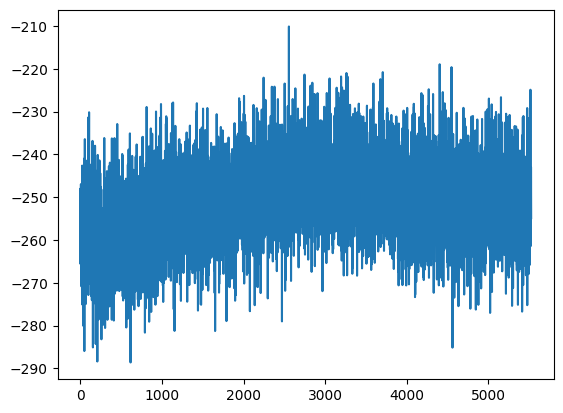

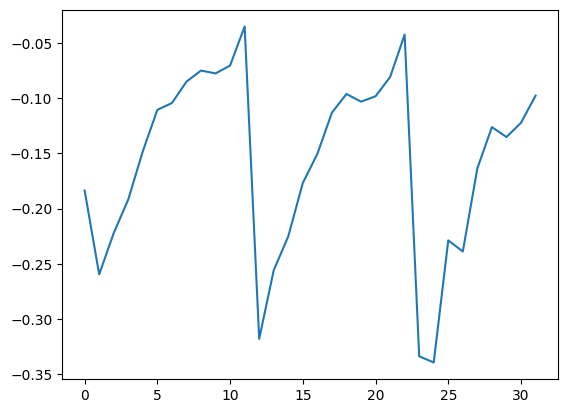

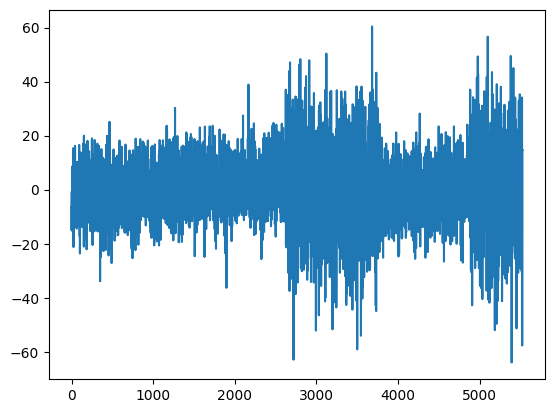

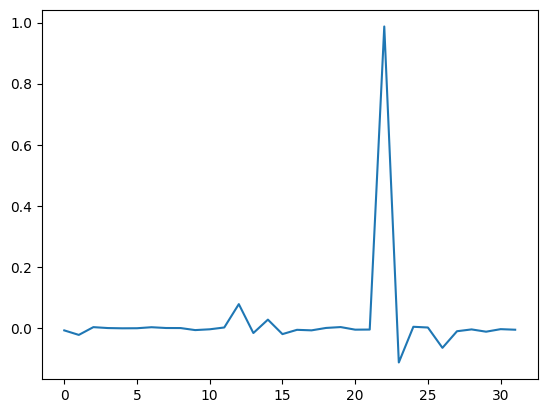

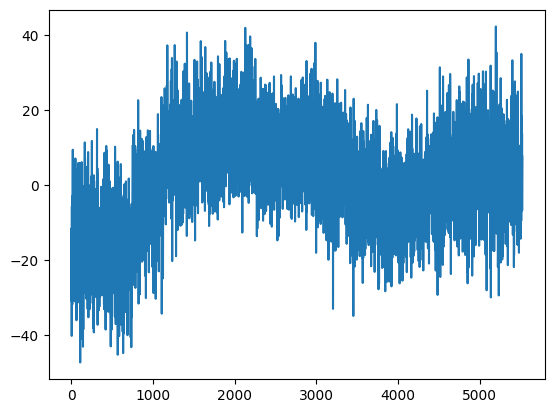

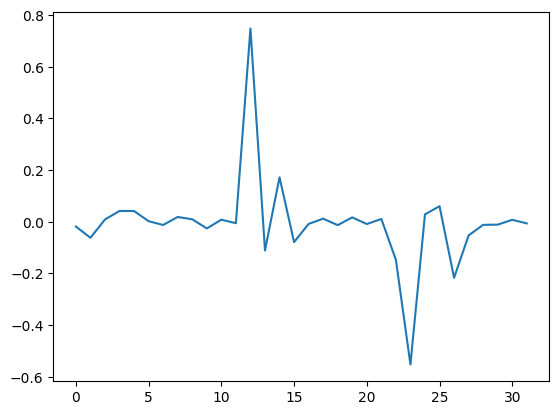

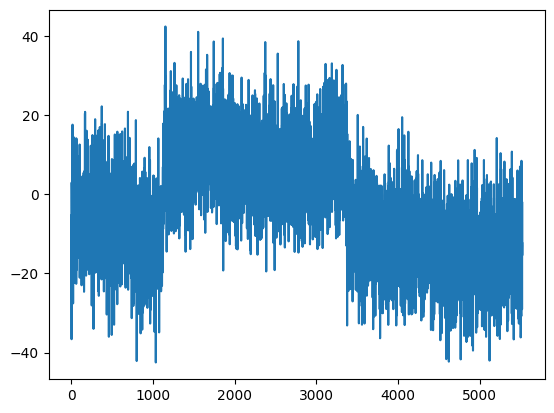

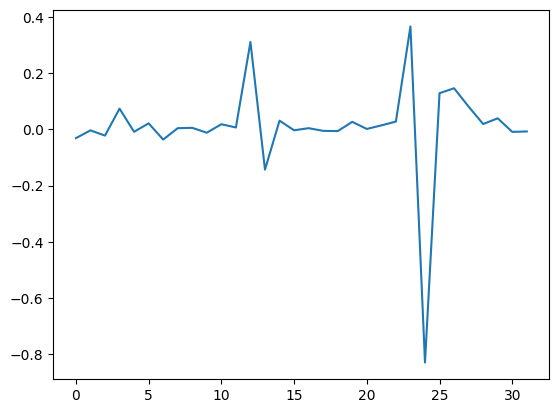

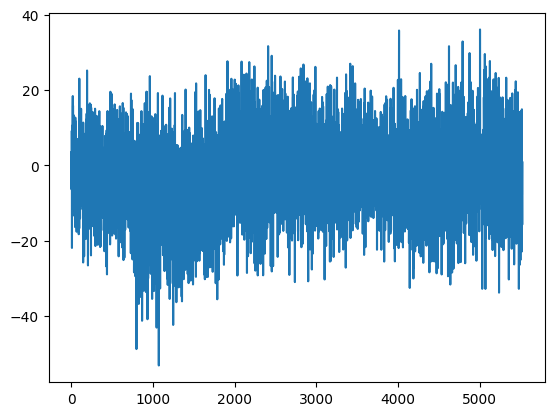

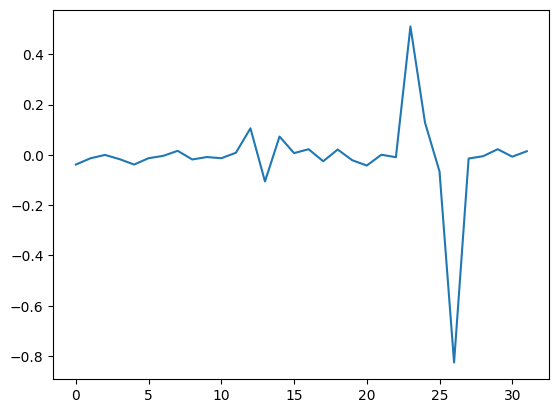

0.028288


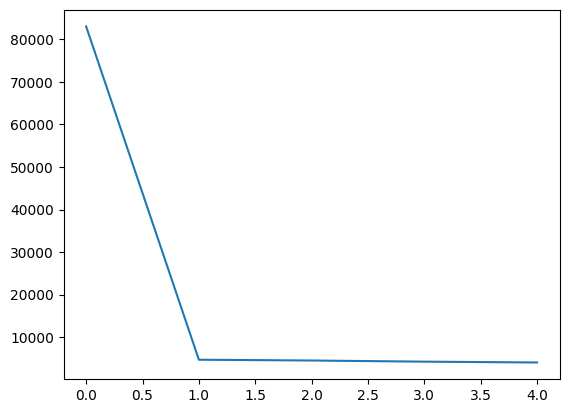

In [21]:
if True:
    #R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='C')#[:50000,...]
    R_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='F').reshape(-1,32,282)#[:50000,...]    
    for i_wavelength in [0]:#range(282):
        this_data = cp.array(R_col[:,:,i_wavelength])
        C_combined = []; S_combined= []
        for ii in range(5):
            W,C,S = ariel_numerics.nan_pca(this_data, n_components=1, verbose=False)
            plt.figure()
            plt.plot(W[:5*1105].get())
            #plt.figure()
            #plt.imshow(C.reshape(32,32).ipynb_checkpoints/get())
            this_data = this_data - W@C
            C_combined.append(C)
            S_combined.append(S)
            plt.figure()
            plt.plot(C.get().T)
            plt.pause(0.001)
        print(np.prod(this_data.shape)*8/1e9)
    plt.figure()
    plt.plot(cp.array(S_combined).get())
#     importlib.reload(ariel_numerics)
#     kgs.profiling = False
#     W_combined = np.zeros((R_row.shape[0],0))
#     C_combined = np.zeros((0,R_row.shape[1]))
#     for ii in range(3):
#         W,C,S=ariel_numerics.nan_pca_rank1_memmap(R_row, R_col, W_combined, C_combined, row_batch = 4096, col_batch = 32, verbose=True, acc_dtype=np.float32, max_iter=10)
#         W_combined = np.concatenate((W_combined, W[:,None]),1)
#         C_combined = np.concatenate((C_combined, C),0)
        
        
#     kgs.dill_save(kgs.calibration_dir + 'AIRS_jitter.pickle', (C_combined, W_combined))

# C_combined, W_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_jitter.pickle')
# for ii in range(3):
#     #plt.figure(figsize=(20,20))
#     plt.figure()
#     plt.imshow(C_combined[ii,:].reshape(32,282), aspect='auto', interpolation='none')

In [4]:
R_col.shape

(110500, 32, 282)

In [9]:
W.shape,C.shape

((110500, 1), (1, 32))

In [16]:
C

array([[-4.3431520e-03,  4.0778751e-03, -3.6639681e-03,  1.0265035e-02,
         2.7303195e-03,  2.0621323e-03,  4.8689996e-03, -1.9213497e-03,
        -3.0984241e-03,  9.3363393e-03,  2.8766782e-03,  1.0807408e-03,
        -3.8726628e-03,  6.0839807e-03, -1.1974678e-02, -5.0679585e-03,
         1.0762011e-04,  5.4063937e-03, -1.8169568e-03,  5.5032200e-03,
         9.9955064e-01, -6.2735570e-03,  7.0352633e-03, -5.8251903e-03,
         1.6923808e-05, -1.6014639e-03,  2.9244815e-04,  9.3794835e-05,
        -1.0053095e-03, -1.3204839e-03, -1.2161770e-02,  6.2307678e-03]],
      dtype=float32)

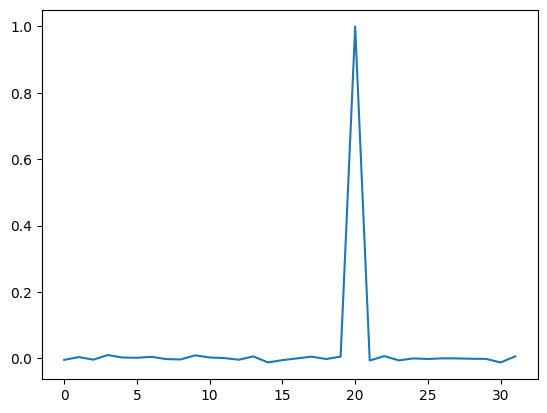

In [19]:
plt.figure()
plt.plot(C.get().T)